In [2]:
# pyqubo stuff
from pyqubo import Array, Constraint


import math
import matplotlib.pyplot as plt
import numpy as np
import random
import re

## Constants

In [4]:
SQUARE_SIZE = 3
BITS = (SQUARE_SIZE * SQUARE_SIZE) - 1

In [5]:
# get the vector index given the i, j, k magic square matrix identifiers
def get_index(i, j, k):
    
    # we need to know the length of the magic square matrix horizontally
    row_length = BITS * SQUARE_SIZE
    
    return int((i*row_length) + (j*BITS) + k)

## Magic Square Implementation

$$\sum_{i1\neq i2}^n\left[\sum_{j=1}^{n}\sum_{k=1}^{s}{x_{i2,j,k}} - \sum_{j=1}^{n}\sum_{k=1}^{s}{x_{i1,j,k}}\right]^2$$

In [6]:
def penalty_sum_row(H, variables, penalty=1):
    for row1 in range(SQUARE_SIZE):
        for row2 in range(SQUARE_SIZE):
            if row1 == row2:
                continue
            
            H_tmp = 0
            
            for j in range(SQUARE_SIZE):
                for k in range(BITS):
                    H_tmp += Constraint(variables[get_index(row2, j, k)], label=f"row2_{row2}_{j}_{k}")

            for j in range(SQUARE_SIZE):
                for k in range(BITS):
                    H_tmp -= Constraint(variables[get_index(row1, j, k)], label=f"row1_{row1}_{j}_{k}")

            H_tmp **= 2
            H += H_tmp

    return penalty * H
            

$$\sum_{j1\neq j2}^n\left[\sum_{i=1}^{n}\sum_{k=1}^{s}{x_{i,j2,k}} - \sum_{i=1}^{n}\sum_{k=1}^{s}{x_{i,j1,k}}\right]^2$$

In [7]:
def penalty_sum_col(H, variables, penalty=1):
    for col1 in range(SQUARE_SIZE):
        for col2 in range(SQUARE_SIZE):
            if col1 == col2:
                continue
            
            H_tmp = 0
            
            for i in range(SQUARE_SIZE):
                for k in range(BITS):
                    H_tmp += Constraint(variables[get_index(i, col2, k)], label=f"col1_{i}_{col2}_{k}")

            for i in range(SQUARE_SIZE):
                for k in range(BITS):
                    H_tmp -= Constraint(variables[get_index(i, col1, k)], label=f"col2_{i}_{col1}_{k}")

            H_tmp **= 2
            H += H_tmp

    return penalty * H
            

$$\sum_{i=1}^{n}\sum_{j=1}^{n}\left[\sum_{k=1}^{s-1}{x_{i,j,k+1} - x_{i,j,k+1}x_{i,j,k}}\right]$$

In [8]:
def penalty_domain_wall(H, variables, penalty=1):
    for i in range(SQUARE_SIZE):
        for j in range(SQUARE_SIZE):
            for k in range(BITS-1):
                H += Constraint(variables[get_index(i,j,k+1)] - (variables[get_index(i,j,k+1)] * variables[get_index(i,j,k)]), label=f"domain_wall_{i}_{j}_{k}")
    return penalty * H   

$$$$

$$\omega_0\sum_{k=1}^{s}\left[\frac{1}{s-k} * \sum_{i=1}^{n}\sum_{j=1}^{n}{x_{i,j,k} - 1}\right] ^ 2$$

In [9]:
def penalty_unique(H, variables, penalty=BITS):
    for k in range(BITS):
        H += Constraint(((1/(BITS-k)) * sum(variables[get_index(i,j,k)] for i in range(SQUARE_SIZE) for j in range(SQUARE_SIZE)) -1 ) ** 2, label=f"unique_{k}")

    return penalty * H

In [10]:
def penalty_unique_2(H, variables, penalty=1):
    for i1 in range(SQUARE_SIZE):
        for j1 in range(SQUARE_SIZE):
            for i2 in range(i1, SQUARE_SIZE):
                for j2 in range(SQUARE_SIZE):
                    if i1 == i2 and j2 <= j1:
                        continue
                            
                    H += Constraint(1 - (1 / BITS) * sum((variables[get_index(i1, j1, k)] - variables[get_index(i2, j2, k)]) ** 2 for k in range(BITS)), label=f"unique_{i1}_{j1}_{i2}_{j2}")
    return H
    

## Construct QUBO

((1.000000 * ((((-1.000000 * Constraint(Binary('x[71]'), 'col2_2_2_7')) + (-1.000000 * Constraint(Binary('x[70]'), 'col2_2_2_6')) + (-1.000000 * Constraint(Binary('x[69]'), 'col2_2_2_5')) + (-1.000000 * Constraint(Binary('x[68]'), 'col2_2_2_4')) + (-1.000000 * Constraint(Binary('x[67]'), 'col2_2_2_3')) + (-1.000000 * Constraint(Binary('x[66]'), 'col2_2_2_2')) + (-1.000000 * Constraint(Binary('x[65]'), 'col2_2_2_1')) + (-1.000000 * Constraint(Binary('x[64]'), 'col2_2_2_0')) + (-1.000000 * Constraint(Binary('x[47]'), 'col2_1_2_7')) + (-1.000000 * Constraint(Binary('x[46]'), 'col2_1_2_6')) + (-1.000000 * Constraint(Binary('x[45]'), 'col2_1_2_5')) + (-1.000000 * Constraint(Binary('x[44]'), 'col2_1_2_4')) + (-1.000000 * Constraint(Binary('x[43]'), 'col2_1_2_3')) + (-1.000000 * Constraint(Binary('x[42]'), 'col2_1_2_2')) + (-1.000000 * Constraint(Binary('x[41]'), 'col2_1_2_1')) + (-1.000000 * Constraint(Binary('x[40]'), 'col2_1_2_0')) + (-1.000000 * Constraint(Binary('x[23]'), 'col2_0_2_7')) 

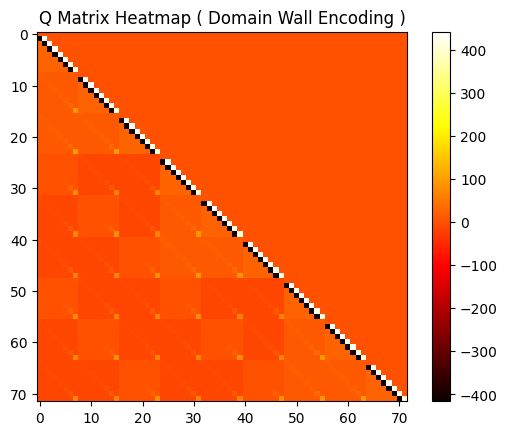

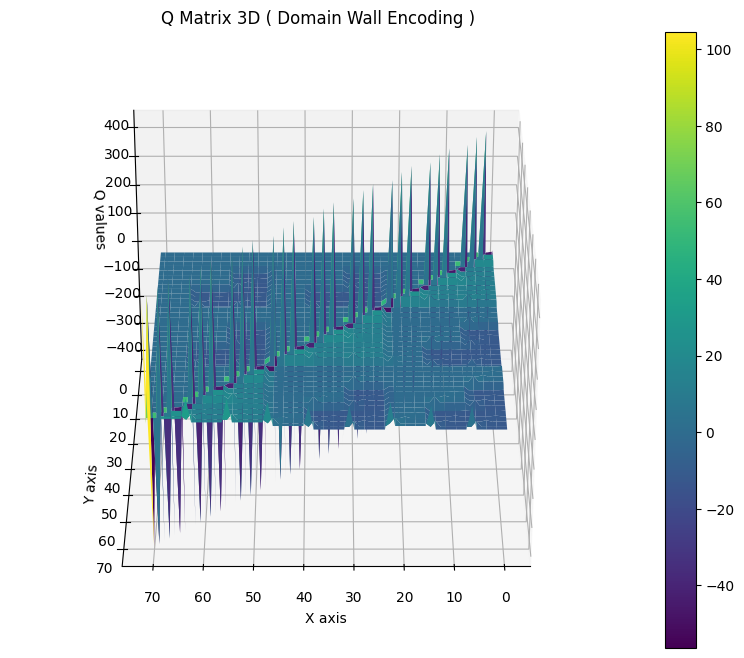

In [13]:
def show_2d(H):
    model = H.compile()
    qubo, offset = model.to_qubo()

    Q = np.zeros((SQUARE_SIZE * SQUARE_SIZE * BITS, SQUARE_SIZE * SQUARE_SIZE * BITS))

    for key, value in qubo.items():
        i = int(re.search(r'\[(\d+)\]', key[0]).group(1))
        j = int(re.search(r'\[(\d+)\]', key[1]).group(1))

        if i > j:
            Q[i][j] = value
        elif i <= j:
            Q[j][i] = value

        


    plt.title("Q Matrix Heatmap ( Domain Wall Encoding )")
    plt.imshow(Q, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.show()

def show_3d(H):

    model = H.compile()
    qubo, offset = model.to_qubo()

    Q = np.zeros((SQUARE_SIZE * SQUARE_SIZE * BITS, SQUARE_SIZE * SQUARE_SIZE * BITS))

    for key, value in qubo.items():
        i = int(re.search(r'\[(\d+)\]', key[0]).group(1))
        j = int(re.search(r'\[(\d+)\]', key[1]).group(1))

        Q[i][j] = value
    
    # Create a meshgrid for the indices of the Q matrix
    x = np.arange(Q.shape[0])
    y = np.arange(Q.shape[1])
    x, y = np.meshgrid(x, y)

    # Create a figure and a 3D axis
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface
    surf = ax.plot_surface(x, y, Q, cmap='viridis')

    # Add a color bar which maps values to colors
    fig.colorbar(surf)
        
    # Set labels
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Q values')

    # Set title
    ax.set_title('Q Matrix 3D ( Domain Wall Encoding )')

    ax.view_init(elev=30, azim=90)  # Adjust 'elev' as needed for better visibility

    plt.show()

array = Array.create('x', SQUARE_SIZE * SQUARE_SIZE * BITS, 'BINARY')

# apply constraints
H = 0
H += penalty_domain_wall(H, array, 10)
H += penalty_unique(H, array, 10)
# H += penalty_unique_2(H, array, 1)

H += penalty_sum_row(H, array, 1)
H += penalty_sum_col(H, array, 1)

print(H)

show_2d(H)
show_3d(H)




## Simulated Annealing

In [16]:
import neal

# compile and convert to binary quadratic model
model = H.compile()
bqm = model.to_bqm()

# simulate
sa = neal.SimulatedAnnealingSampler()
sampleset = sa.sample(bqm, num_reads=5000)
decoded_samples = model.decode_sampleset(sampleset)

# decode
solutions = []

for solution in decoded_samples:
    
    # get the sample and energy
    sample = solution.sample
    energy = solution.energy

    # split the sample values into bit sized chunks
    # sample = np.array([list(sample.values())[i:i+BITS] for i in range(0, len(sample), BITS)]).reshape((SQUARE_SIZE, SQUARE_SIZE, BITS))
    sample = np.array([sample[f"x[{i}]"] for i in range(SQUARE_SIZE * SQUARE_SIZE * BITS)]).reshape((SQUARE_SIZE, SQUARE_SIZE, BITS))  

    solutions.append({"sample": sample, "energy": energy})

## Real Annealing

## Analysis 

In [17]:
def to_decimal(item):
    if [1] * item.count(1) + [0] * item.count(0) == item:
        return sum(item)
    return -1

def get_grid(sample):
    grid = np.zeros((SQUARE_SIZE, SQUARE_SIZE))
    
    for i in range(SQUARE_SIZE):
        for j in range(SQUARE_SIZE):

            # get the item
            item = list(sample[i][j])
            
            grid[i][j] = to_decimal(item)
            
    return np.array(grid)

def check_unary(sample):

    count = 0
    for i in range(SQUARE_SIZE):
        for j in range(SQUARE_SIZE):
            item = list(map(int, sample[i][j]))
            
            if [1] * item.count(1) + [0] * item.count(0) != item:
                count += 1

    if count == 0:
        return True
    
    return count

def check_unique(sample):
    grid = get_grid(sample)

    if len(set(grid.flatten())) == SQUARE_SIZE * SQUARE_SIZE:
        return True
    return False
    
def check_sum_col(sample):

    # get grid and sum cols
    grid = get_grid(sample)
    sums = [int(sum(grid[:,i])) for i in range(SQUARE_SIZE)]

    # test for equality
    if len(set(sums)) == 1:
        return True
    return False

def check_sum_row(sample):
    
    # get grid and sum rows
    grid = get_grid(sample)
    sums = [int(sum(grid[i,:])) for i in range(SQUARE_SIZE)]

    # test for equality
    if len(set(sums)) == 1:
        return True
    return False

def is_magic(sample):
    return check_unary(sample) and check_unique(sample) and check_sum_col(sample) and check_sum_row(sample)


unary_incorrect = {}

unary = 0
unique = 0
sumcol = 0
sumrow = 0
magic = 0


for solution in solutions:
    
    if check_unary(solution["sample"]) is True:
        unary += 1
    else:
        if check_unary(solution["sample"]) not in unary_incorrect:
            unary_incorrect.setdefault(check_unary(solution["sample"]), 1)
        else:
            unary_incorrect[check_unary(solution["sample"])] += 1
        continue
    
    if check_unique(solution["sample"]):
        unique += 1

    if check_sum_col(solution["sample"]):
        sumcol += 1

    if check_sum_row(solution["sample"]):
        sumrow += 1

    if is_magic(solution["sample"]):
        print(get_grid(solution["sample"]))
        magic += 1

print(f"Unary Correct: {unary}/{len(solutions)}")
print(f"Unique Correct: {unique}/{len(solutions)}")
print(f"Sum Column Correct: {sumcol}/{len(solutions)}")
print(f"Sum Row Correct: {sumrow}/{len(solutions)}")
print(f"OHE Incorrect: {unary_incorrect}")
print(f"Magic Correct: {magic}/{len(solutions)}")


[[10.  3. 13.  4.]
 [ 8. 15.  6.  1.]
 [12.  5.  2. 11.]
 [ 0.  7.  9. 14.]]
[[15.  3.  2. 10.]
 [ 4. 12. 13.  1.]
 [11.  8.  6.  5.]
 [ 0.  7.  9. 14.]]
[[ 4. 11.  1. 14.]
 [15.  8.  7.  0.]
 [ 2.  5. 10. 13.]
 [ 9.  6. 12.  3.]]
[[13. 10.  7.  0.]
 [11.  5.  8.  6.]
 [ 4. 14.  3.  9.]
 [ 2.  1. 12. 15.]]
[[ 3. 12. 13.  2.]
 [ 9. 10.  5.  6.]
 [ 4.  0. 11. 15.]
 [14.  8.  1.  7.]]
[[ 1. 12. 14.  3.]
 [ 4.  9. 11.  6.]
 [15.  2.  5.  8.]
 [10.  7.  0. 13.]]
[[ 4.  9. 14.  3.]
 [ 0. 13.  7. 10.]
 [11.  6.  8.  5.]
 [15.  2.  1. 12.]]
[[ 7.  3.  8. 12.]
 [14. 13.  1.  2.]
 [ 0.  4. 15. 11.]
 [ 9. 10.  6.  5.]]
Unary Correct: 5000/5000
Unique Correct: 8/5000
Sum Column Correct: 5000/5000
Sum Row Correct: 5000/5000
OHE Incorrect: {}
Magic Correct: 8/5000


## Show Example

In [35]:
# condense into count
def condense_results(solutions):
    
    condensed = {}
    
    for solution in solutions:
        sample = solution["sample"]
        energy = solution["energy"]

        # extract the values
        key = str(sample.flatten())
        
        if key not in condensed:
            condensed[key] = {"count": 0, "energy": energy, "sample": sample}
        
        condensed[key]["count"] += 1
    
    return condensed

condensed = condense_results(solutions)

for key, value in condensed.items():
    # show the raw sample
    # print(np.array(key).reshape((SQUARE_SIZE, SQUARE_SIZE, BITS)))
    # print(np.array(key).reshape((SQUARE_SIZE, SQUARE_SIZE, BITS)))
    print(value["sample"])
    print(get_grid(np.array([int(i) for i in key[1:-1].split(" ")]).reshape((SQUARE_SIZE, SQUARE_SIZE, BITS))))
    print(f"count: {value['count']}")
    print(f"energy: {value['energy']}")
    
    
    print("\n\n")

[[[1 1 1 1 1 1 1 1 1 0 0 0 0 0 0]
  [1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
  [1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
  [1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]]

 [[1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
  [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]

 [[1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
  [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0]
  [1 1 1 1 1 1 1 1 1 1 1 1 1 0 0]]

 [[1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
  [1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
  [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
  [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0]]]
[[ 9.  8.  7.  6.]
 [14. 15.  1.  0.]
 [ 2.  3. 12. 13.]
 [ 5.  4. 10. 11.]]
count: 1
energy: -9.094947017729282e-12



[[[1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
  [1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
  [1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]]

 [[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
  [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]

 [[1 1 1 1 1 1 1 1 1 1 1 1 0 0 0]
  [1 1 1 0 0 0 0 0